# Conditional Diffusion Model

## Architecture Design & Rationale

    Core Model Components
    The model employs a modular architecture with four specialized components:

    Component  Purpose  Design  Choice
    Stroke EmbedderTransform (x, y, pen_state) → latent space Preserves spatial relationships
    Category EmbedderInject semantic conditioning Enables conditional generation
    Temporal EncoderModel sequential dependencies LSTM for stroke order modeling
    Noise PredictorEstimate diffusion noise Maps latent → coordinate space

## Forward Pass Design
    Triple Conditioning Strategy: stroke_embeddings + category_expanded + timestep_embeddings

    Additive combination preserves individual signal contributions
    Layer normalization ensures training stability
    LSTM processing captures temporal drawing patterns
    LSTM over attention for sequential stroke modeling - validates that temporal order matters more than spatial relationships for sketch generation.

## Training Strategy & Hyperparameter Analysis
    Architecture Dimensions:
        json: {
            "embedding_dim": 256,
            "hidden_dim": 512,
            "lstm_layers": 2,
            "parameters": "~6.2M",
            "rationale": "Balance between expressiveness and efficiency"
        }
    
## Training Configuration
    Epochs: 175-200 (category-dependent optimization)
    Learning Rate: 1e-4 (conservative for stable diffusion training)
    Loss Function: MSE with specialized pen state handling
    Diffusion Steps: 1000 training / 500 inference (efficiency balance)

# Key Implementation Insights
## 1. Diffusion Process

Pen state specialization: Different noise scales for discrete vs continuous components

Coordinate space consistency: [-1, 1] normalization maintained throughout

Generation validation: Automatic pen state clamping ensures valid sequences


## 2. Attention Experiment
Hypothesis: Attention would improve spatial understanding

Result: FID degradation 92.2 → 250.4

Insight: Sequential stroke modeling benefits more from temporal order (LSTM) than spatial relationships (attention)


## 3. Training Efficiency
Loss convergence: 0.036-0.046 across categories indicates optimal hyperparameters

Epoch scaling: More complex categories require longer training (bus: 175, rabbit: 200)

Architecture consistency: Same model works across all categories with different training durations


## 4. Possible Improvements
### Architectural Constraints

Single-category models: No transfer learning between categories

Fixed sequence length: Padding required for variable-length sketches

Semantic gap: Strong statistical quality but limited shape understanding. Model analysis correct corrdintes and pen strikes but does not capure the shape of the sketch

### 5. Model Improvement Directions

Unified multi-category model with shared backbone

Hierarchical generation: Stroke-level then point-level modeling

Semantic conditioning: Stronger category control mechanisms



In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
from datetime import datetime
import math

In [ ]:
# Load preproccesed data
with open("processed_datasets.pkl", "rb") as file:
    processed_datasets = pickle.load(file)

In [4]:
processed_datasets.keys()

dict_keys(['cat', 'rabbit', 'bus'])

In [ ]:
# Function to create a base diffusion model
def diffusion_model(embedding_dim=256, hidden_dim=512, num_categories=3, num_layers=3, dropout=0.1):
    # Stroke embedder: [x, y, pen_state] -> embedding
    stroke_embedder = nn.Sequential(
        nn.Linear(3, embedding_dim),
        nn.LayerNorm(embedding_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(embedding_dim, embedding_dim),
        nn.LayerNorm(embedding_dim)
    )

    # Category embedder: category_id -> embedding
    category_embedder = nn.Embedding(num_categories, embedding_dim)

    # Temporal encoder: LSTM for sequence modeling
    temporal_encoder = nn.LSTM(
        input_size=embedding_dim,
        hidden_size=hidden_dim,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout if num_layers > 1 else 0,
        bidirectional=False
    )

    # Noise predictor: hidden_states -> predicted_noise
    noise_predictor = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, hidden_dim // 2),
        nn.ReLU(),
        nn.Dropout(dropout * 0.5),  # Less dropout in final layers
        nn.Linear(hidden_dim // 2, 3)
    )

    model_components = {
        'stroke_embedder': stroke_embedder,
        'category_embedder': category_embedder,
        'temporal_encoder': temporal_encoder,
        'noise_predictor': noise_predictor
    }

    return model_components

In [6]:
processed_datasets['rabbit']['train_data'].shape

(10000, 571, 3)

In [7]:
def create_timestep_embedding(timesteps, embedding_dim, device):
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

    # Pad if odd dimension
    if embedding_dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)

    return emb

In [8]:
def model_forward_training(sequences, model_components, categories, timesteps):
    # Get components
    stroke_embedder = model_components['stroke_embedder']
    category_embedder = model_components['category_embedder']
    temporal_encoder = model_components['temporal_encoder']
    noise_predictor = model_components['noise_predictor']

    batch_size, seq_len, _ = sequences.shape

    # Embded stroke sequences
    stroke_embeddings = stroke_embedder(sequences) # [batch, seq_len, embedding_dim]

    
    # Embed categories and inject into sequence
    category_embeddings = category_embedder(categories)  # [batch, embedding_dim]
    category_expanded = category_embeddings.unsqueeze(1).expand(-1, seq_len, -1)

    # Add timestep conditioning
    device = sequences.device
    t_emb = create_timestep_embedding(timesteps, stroke_embeddings.shape[-1], device)
    t_expanded = t_emb.unsqueeze(1).expand(-1, seq_len, -1)

    # Combine stroke and category embeddings
    conditioned_embeddings = stroke_embeddings + category_expanded + t_expanded
    conditioned_embeddings = F.layer_norm(conditioned_embeddings, conditioned_embeddings.shape[-1:])

    # Process through LSTM
    lstm_output, _ = temporal_encoder(conditioned_embeddings)  # [batch, seq_len, hidden_dim]

    # Predict noise
    predicted_noise = noise_predictor(lstm_output)

    return predicted_noise

In [ ]:
# Create progressive noise schedule for diffusion
def create_noise_schedule(timesteps=1000):
    s = 0.008
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)

    # Cosine schedule formula
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # Normalize

    # Calculate betas from alphas
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clip(betas, 0.0001, 0.02)  # Clamp for stability

    alphas = 1 - betas
    alphas_cumprod = alphas_cumprod[1:]

    noise_schedule = {
        'betas': betas,
        'alphas': alphas,
        'alphas_cumprod': alphas_cumprod,
        'timesteps': timesteps
    }

    return noise_schedule

In [ ]:
# Noise addittion for sketch generation
def noise_addition(sequences, noise, timesteps, noise_schedule):
    alphas_cumprod_t = noise_schedule['alphas_cumprod'][timesteps].reshape(-1, 1, 1)
    alphas_cumprod_t = torch.clamp(alphas_cumprod_t, 0.001, 0.999)

    noisy_sequences = torch.sqrt(alphas_cumprod_t) * sequences + \
                     torch.sqrt(1 - alphas_cumprod_t) * noise
    noisy_sequences = torch.clamp(noisy_sequences, -3.0, 3.0)
    
    return noisy_sequences

In [11]:
def create_dataloader(dataset, batch_size=128):
    category_mapping = {
    'cat': 0,
    'bus': 1,
    'rabbit': 2
    }

    category_name = dataset['category']
    category_id = category_mapping[category_name]

    # Get data
    train_data = dataset['train_data']
    test_data = dataset['test_data']

    # Convert train data to torch
    train_sequences = torch.FloatTensor(train_data)
    train_categories = torch.full((len(train_data),), category_id, dtype=torch.long)

    # Convert test data to torch
    test_sequences = torch.FloatTensor(test_data)
    test_categories = torch.full((len(test_data),), category_id, dtype=torch.long)

    # Create datasets
    train_dataset = TensorDataset(train_sequences, train_categories)
    test_dataset = TensorDataset(test_sequences, test_categories)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Train: {len(train_dataset)} samples, {len(train_loader)} batches")
    print(f"Test: {len(test_dataset)} samples, {len(test_loader)} batches")

    return train_loader, test_loader

In [12]:
rabbit_train_loader, rabbit_test_loader = create_dataloader(processed_datasets['rabbit'])

Train: 10000 samples, 79 batches
Test: 2000 samples, 16 batches


In [13]:
# Setup device
def setup_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

In [ ]:
# Learning rate decay scheduler
def create_lr_scheduler(optimizer, num_epochs, lr, total_steps):
    warmup_steps = min(1000, total_steps // 10)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=total_steps, pct_start=warmup_steps/total_steps, anneal_strategy='cos')
    return scheduler

In [14]:
# Setup adam optimizer
def initialize_optimizer(model_components, lr, num_epochs, total_steps):
    # Collect all parameters from all components
    all_params = []
    total_params = 0

    for _, component in model_components.items():
        component_params = list(component.parameters())
        all_params.extend(component_params)
        num_params = sum(p.numel() for p in component_params)
        total_params += num_params

    # Create optimizer
    optimizer = torch.optim.AdamW(all_params, lr=lr, weight_decay=1e-6)

    # Learning decay scheduler
    scheduler = create_lr_scheduler(optimizer, num_epochs, lr, total_steps)

    print(f"Total parameters: {total_params:,}")
    print(f"Learning rate: {lr}")

    return optimizer, scheduler, all_params, total_params

In [ ]:
def save_model_complete(model_components, noise_schedule, loss_history, num_epochs, learning_rate, total_params, category_name,save_to_drive=True):
    # Create filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"sketch_diffusion_{category_name}_{timestamp}.pth"

    if save_to_drive:
        # Mount Google Drive
        try:
            from google.colab import drive
            drive.mount('/content/drive', force_remount=True)
            save_path = '/content/drive/MyDrive/sketch_models'
            os.makedirs(save_path, exist_ok=True)
            model_path = os.path.join(save_path, model_filename)
        except:
            print("Drive mount failed, saving locally")
            save_path = './models'
            os.makedirs(save_path, exist_ok=True)
            model_path = os.path.join(save_path, model_filename)
    else:
         # Check if we're in local environment
        if '/kaggle/working' in os.getcwd():
            save_path = '/kaggle/working/models'
            print("Detected Kaggle environment - saving to /kaggle/working/models")
        else:
            save_path = './models'
            print("Saving to local ./models directory")
        
        os.makedirs(save_path, exist_ok=True)
        model_path = os.path.join(save_path, model_filename)

    save_dict = {
        'model_components': model_components,
        'noise_schedule': noise_schedule,
        'loss_history': loss_history,
        'training_info': {
            'num_epochs': num_epochs,
            'learning_rate': learning_rate,
            'final_loss': loss_history[-1] if loss_history else 0,
            'best_loss': min(loss_history) if loss_history else 0,
            'category': category_name,
            'total_parameters': total_params,
            'timestamp': timestamp
        }
    }

    # Save model
    torch.save(save_dict, model_path)

    print(f"Complete model saved to: {model_path}")
    print(f"Final loss: {loss_history[-1]:.4f}")
    print(f"Best loss: {min(loss_history):.4f}")
    print(f"Category: {category_name}")

    return model_path

In [27]:
# Helper function to train the model one epochs
def train_one_epoch(model_components, dataloader, noise_schedule, optimizer, device, all_params):
    # Set parameters
    total_loss = 0
    num_batches = 0

    # Set models to training mode
    for component in model_components.values():
        component.train()

    for batch_idx, (sequences, categories) in enumerate(tqdm(dataloader, desc="Training")):

        # Move data to device
        sequences = sequences.to(device)
        categories = categories.to(device)
        batch_size = sequences.shape[0]

        # Sample random timesteps for diffusion
        timesteps = torch.randint(0, noise_schedule['timesteps'], (batch_size,), device=device)

        # Generate noise (only for coordinates, not stroke state)
        noise = torch.randn_like(sequences, device=device)
        noise[:, :, 2] = 0  # No noise on stroke state

        # Add progressive noise to sequences
        noisy_sequences = noise_addition(sequences, noise, timesteps, noise_schedule)

        # Forward pass through model
        predicted_noise = model_forward_training(noisy_sequences, model_components, categories, timesteps)

        # Compute weighted loss
        coord_loss = F.mse_loss(predicted_noise[:, :, :2], noise[:, :, :2])
        pen_loss = F.mse_loss(predicted_noise[:, :, 2:], noise[:, :, 2:])
        loss = coord_loss + 0.3 * pen_loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(all_params, max_norm=1.0)


        optimizer.step()

        # Track loss
        total_loss += loss.item()
        num_batches += 1

        # Print progress every 30 batches
        if batch_idx % 50 == 0:
            print(f"\nBatch{batch_idx:3d}: Loss = {loss.item():.4f}")

    # Calculate average loss
    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    print(f"Epoch completed: Average Loss = {avg_loss:.4f}")

    return avg_loss

In [17]:
# Full traning loop to train model
def train_model(model_components, dataloader, num_epochs, learning_rate):
    print("STARTING TRAINING")
    print(f"Epochs: {num_epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Batches per epoch: {len(dataloader)}")

    # Initialize device
    device = setup_device()
    if device.type == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name()}")

    # Initialize noise scheduler
    noise_schedule = create_noise_schedule(timesteps=1000)

    for key in noise_schedule:
        if isinstance(noise_schedule[key], torch.Tensor):
            noise_schedule[key] = noise_schedule[key].to(device)

    # Move models to device
    for name, component in model_components.items():
        model_components[name] = component.to(device)

    # Move noise schedule to device
    for key, value in noise_schedule.items():
        if isinstance(value, torch.Tensor):
            noise_schedule[key] = value.to(device)

    # Initialize adam optimizer
    total_steps = dataloader.dataset.tensors[0].shape[0] // dataloader.batch_size * num_epochs
    optimizer, scheduler, all_params, total_params = initialize_optimizer(model_components, learning_rate, num_epochs, total_steps)

    print("\nSTARTING TRAINING LOOP")
    loss_history = []

    for epoch in range(num_epochs):
        print(f"\nEPOCH {epoch + 1}/{num_epochs}")

        # Train one epoch
        avg_loss = train_one_epoch(model_components, dataloader, noise_schedule, optimizer, device, all_params)
        loss_history.append(avg_loss)
        scheduler.step()

        print(f"Loss: {avg_loss:.4f} | LR: {learning_rate:.2e}")

        # Save checkpoint every 20 epochs
        if (epoch + 1) % 50 == 0:
            print(f"Checkpoint at epoch {epoch + 1}")

    # Get first batch to determine category
    first_batch = next(iter(dataloader))
    category_id = first_batch[1][0].item()
    category_names = {0: 'cat', 1: 'bus', 2: 'rabbit'}
    category_name = category_names.get(category_id, f'category_{category_id}')

    model_path = save_model_complete(
        model_components=model_components,
        noise_schedule=noise_schedule,
        loss_history=loss_history,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        total_params=total_params,
        category_name=category_name,
        save_to_drive=False
    )

    print(f"Model saved to: {model_path}")
    print(f"Final loss: {loss_history[-1]:.4f}")
    print(f"Best loss: {min(loss_history):.4f}")
    print(f"Category: {category_name}")

    return model_components, loss_history, model_path

In [18]:
def plot_training_loss(loss_history):
    print("\nPLOTTING TRAINING LOSS")

    plt.figure(figsize=(10, 6))

    # Plot loss
    epochs = range(1, len(loss_history) + 1)
    plt.plot(epochs, loss_history, 'b-', linewidth=2, marker='o', markersize=6)

    # Formatting
    plt.title('Training Loss Over Epochs', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Add loss values on points
    for i, loss in enumerate(loss_history):
        plt.annotate(f'{loss:.4f}', (i+1, loss), textcoords="offset points",
                    xytext=(0,10), ha='center', fontsize=9)

    # Add statistics
    final_loss = loss_history[-1]
    best_loss = min(loss_history)
    best_epoch = loss_history.index(best_loss) + 1

    plt.text(0.02, 0.98, f'Final Loss: {final_loss:.4f}\nBest Loss: {best_loss:.4f} (Epoch {best_epoch})',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print("Training Summary:")
    print(f"Total epochs: {len(loss_history)}")
    print(f"Final loss: {final_loss:.4f}")
    print(f"Best loss: {best_loss:.4f} (Epoch {best_epoch})")
    print(f"Loss improvement: {((loss_history[0] - final_loss) / loss_history[0] * 100):.1f}%")

In [19]:
model_components = diffusion_model()

In [29]:
trained_model, loss_history, model_path = train_model(
        model_components=model_components,
        dataloader=rabbit_train_loader,
        num_epochs=200,
        learning_rate=1e-4)

STARTING TRAINING
Epochs: 200
Learning rate: 0.0001
Batches per epoch: 79
GPU: Tesla P100-PCIE-16GB
Total parameters: 6,242,819
Learning rate: 0.0001

STARTING TRAINING LOOP

EPOCH 1/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.87it/s]


Batch  0: Loss = 1.0027


Training:  65%|██████▍   | 51/79 [00:26<00:14,  1.91it/s]


Batch 50: Loss = 0.9963


Training: 100%|██████████| 79/79 [00:41<00:00,  1.93it/s]


Epoch completed: Average Loss = 0.9994
Loss: 0.9994 | LR: 1.00e-04

EPOCH 2/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.93it/s]


Batch  0: Loss = 1.0010


Training:  65%|██████▍   | 51/79 [00:26<00:14,  1.90it/s]


Batch 50: Loss = 0.9953


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.9968
Loss: 0.9968 | LR: 1.00e-04

EPOCH 3/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.9985


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.9944


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.9920
Loss: 0.9920 | LR: 1.00e-04

EPOCH 4/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.9882


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.9678


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.9694
Loss: 0.9694 | LR: 1.00e-04

EPOCH 5/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.9425


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.8532


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.8711
Loss: 0.8711 | LR: 1.00e-04

EPOCH 6/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.7493


Training:  65%|██████▍   | 51/79 [00:26<00:14,  1.89it/s]


Batch 50: Loss = 0.5418


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.5911
Loss: 0.5911 | LR: 1.00e-04

EPOCH 7/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.4191


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.2634


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.3055
Loss: 0.3055 | LR: 1.00e-04

EPOCH 8/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.2461


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.2477


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.2326
Loss: 0.2326 | LR: 1.00e-04

EPOCH 9/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.2203


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.2140


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.2207
Loss: 0.2207 | LR: 1.00e-04

EPOCH 10/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.2086


Training:  65%|██████▍   | 51/79 [00:26<00:14,  1.89it/s]


Batch 50: Loss = 0.1932


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.2099
Loss: 0.2099 | LR: 1.00e-04

EPOCH 11/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.2107


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.2023


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.2008
Loss: 0.2008 | LR: 1.00e-04

EPOCH 12/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.1949


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.1849


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1932
Loss: 0.1932 | LR: 1.00e-04

EPOCH 13/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.2140


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.1849


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1835
Loss: 0.1835 | LR: 1.00e-04

EPOCH 14/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.1738


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.1647


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1722
Loss: 0.1722 | LR: 1.00e-04

EPOCH 15/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.1552


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.1406


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1613
Loss: 0.1613 | LR: 1.00e-04

EPOCH 16/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.1688


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.1392


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1528
Loss: 0.1528 | LR: 1.00e-04

EPOCH 17/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.1474


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.1670


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1414
Loss: 0.1414 | LR: 1.00e-04

EPOCH 18/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.1231


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.1170


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1319
Loss: 0.1319 | LR: 1.00e-04

EPOCH 19/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.1219


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.1359


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1248
Loss: 0.1248 | LR: 1.00e-04

EPOCH 20/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.1275


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.1370


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1200
Loss: 0.1200 | LR: 1.00e-04

EPOCH 21/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.1243


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.1182


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1120
Loss: 0.1120 | LR: 1.00e-04

EPOCH 22/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.1349


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.1291


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1099
Loss: 0.1099 | LR: 1.00e-04

EPOCH 23/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.1148


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.90it/s]


Batch 50: Loss = 0.1109


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.1050
Loss: 0.1050 | LR: 1.00e-04

EPOCH 24/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.1247


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0986


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.1021
Loss: 0.1021 | LR: 1.00e-04

EPOCH 25/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0969


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.1068


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0986
Loss: 0.0986 | LR: 1.00e-04

EPOCH 26/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0853


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0918


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0971
Loss: 0.0971 | LR: 1.00e-04

EPOCH 27/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0826


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0864


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0930
Loss: 0.0930 | LR: 1.00e-04

EPOCH 28/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0801


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.1173


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.0923
Loss: 0.0923 | LR: 1.00e-04

EPOCH 29/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.1021


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0779


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.0889
Loss: 0.0889 | LR: 1.00e-04

EPOCH 30/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0917


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0826


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0876
Loss: 0.0876 | LR: 1.00e-04

EPOCH 31/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0764


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0759


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0857
Loss: 0.0857 | LR: 1.00e-04

EPOCH 32/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0746


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0697


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0846
Loss: 0.0846 | LR: 1.00e-04

EPOCH 33/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0821


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0802


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0828
Loss: 0.0828 | LR: 1.00e-04

EPOCH 34/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0937


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0841


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0798
Loss: 0.0798 | LR: 1.00e-04

EPOCH 35/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0796


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0740


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0800
Loss: 0.0800 | LR: 1.00e-04

EPOCH 36/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0870


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0659


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0786
Loss: 0.0786 | LR: 1.00e-04

EPOCH 37/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0703


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0799


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0763
Loss: 0.0763 | LR: 1.00e-04

EPOCH 38/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0741


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0707


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0748
Loss: 0.0748 | LR: 1.00e-04

EPOCH 39/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0672


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0642


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0734
Loss: 0.0734 | LR: 1.00e-04

EPOCH 40/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0668


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0711


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0720
Loss: 0.0720 | LR: 1.00e-04

EPOCH 41/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0704


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0636


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0728
Loss: 0.0728 | LR: 1.00e-04

EPOCH 42/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0754


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0762


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0715
Loss: 0.0715 | LR: 1.00e-04

EPOCH 43/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0691


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0675


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0687
Loss: 0.0687 | LR: 1.00e-04

EPOCH 44/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0755


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0686


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0694
Loss: 0.0694 | LR: 1.00e-04

EPOCH 45/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0574


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0661


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0673
Loss: 0.0673 | LR: 1.00e-04

EPOCH 46/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0774


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0731


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0651
Loss: 0.0651 | LR: 1.00e-04

EPOCH 47/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.93it/s]


Batch  0: Loss = 0.0611


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0623


Training: 100%|██████████| 79/79 [00:41<00:00,  1.91it/s]


Epoch completed: Average Loss = 0.0657
Loss: 0.0657 | LR: 1.00e-04

EPOCH 48/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0625


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0533


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0636
Loss: 0.0636 | LR: 1.00e-04

EPOCH 49/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0624


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0556


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0624
Loss: 0.0624 | LR: 1.00e-04

EPOCH 50/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0625


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0633


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0616
Loss: 0.0616 | LR: 1.00e-04
Checkpoint at epoch 50

EPOCH 51/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0648


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0578


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0617
Loss: 0.0617 | LR: 1.00e-04

EPOCH 52/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0632


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0666


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0611
Loss: 0.0611 | LR: 1.00e-04

EPOCH 53/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0633


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0604


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0608
Loss: 0.0608 | LR: 1.00e-04

EPOCH 54/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0606


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0569


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0593
Loss: 0.0593 | LR: 1.00e-04

EPOCH 55/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0625


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0602


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0583
Loss: 0.0583 | LR: 1.00e-04

EPOCH 56/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0589


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0565


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0576
Loss: 0.0576 | LR: 1.00e-04

EPOCH 57/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.93it/s]


Batch  0: Loss = 0.0632


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0574


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0562
Loss: 0.0562 | LR: 1.00e-04

EPOCH 58/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0510


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0573


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0562
Loss: 0.0562 | LR: 1.00e-04

EPOCH 59/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0583


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0512


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0553
Loss: 0.0553 | LR: 1.00e-04

EPOCH 60/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0685


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0551


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0552
Loss: 0.0552 | LR: 1.00e-04

EPOCH 61/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0497


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0515


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0542
Loss: 0.0542 | LR: 1.00e-04

EPOCH 62/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0556


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0500


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0544
Loss: 0.0544 | LR: 1.00e-04

EPOCH 63/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0473


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0501


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0532
Loss: 0.0532 | LR: 1.00e-04

EPOCH 64/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0648


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0598


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0533
Loss: 0.0533 | LR: 1.00e-04

EPOCH 65/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0542


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0467


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0535
Loss: 0.0535 | LR: 1.00e-04

EPOCH 66/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0512


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0506


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0521
Loss: 0.0521 | LR: 1.00e-04

EPOCH 67/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0477


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0587


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0524
Loss: 0.0524 | LR: 1.00e-04

EPOCH 68/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0443


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0497


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0514
Loss: 0.0514 | LR: 1.00e-04

EPOCH 69/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0461


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0581


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0515
Loss: 0.0515 | LR: 1.00e-04

EPOCH 70/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0482


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0457


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0510
Loss: 0.0510 | LR: 1.00e-04

EPOCH 71/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0468


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0483


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0506
Loss: 0.0506 | LR: 1.00e-04

EPOCH 72/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0497


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0560


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0513
Loss: 0.0513 | LR: 1.00e-04

EPOCH 73/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0611


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0528


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0503
Loss: 0.0503 | LR: 1.00e-04

EPOCH 74/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0565


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0521


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0501
Loss: 0.0501 | LR: 1.00e-04

EPOCH 75/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0452


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0496


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0491
Loss: 0.0491 | LR: 1.00e-04

EPOCH 76/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0559


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0528


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0493
Loss: 0.0493 | LR: 1.00e-04

EPOCH 77/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0492


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0473


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0492
Loss: 0.0492 | LR: 1.00e-04

EPOCH 78/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0579


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0505


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0493
Loss: 0.0493 | LR: 1.00e-04

EPOCH 79/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0516


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0589


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0490
Loss: 0.0490 | LR: 1.00e-04

EPOCH 80/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0522


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0410


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0476
Loss: 0.0476 | LR: 1.00e-04

EPOCH 81/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0502


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0528


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0488
Loss: 0.0488 | LR: 1.00e-04

EPOCH 82/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0462


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0395


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0483
Loss: 0.0483 | LR: 1.00e-04

EPOCH 83/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0483


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0507


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0481
Loss: 0.0481 | LR: 1.00e-04

EPOCH 84/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0534


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0483


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0478
Loss: 0.0478 | LR: 1.00e-04

EPOCH 85/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0437


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0473


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0474
Loss: 0.0474 | LR: 1.00e-04

EPOCH 86/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0441


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0497


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0470
Loss: 0.0470 | LR: 1.00e-04

EPOCH 87/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0400


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0433


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0466
Loss: 0.0466 | LR: 1.00e-04

EPOCH 88/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0532


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0496


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0463
Loss: 0.0463 | LR: 1.00e-04

EPOCH 89/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0423


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0428


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0469
Loss: 0.0469 | LR: 1.00e-04

EPOCH 90/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0418


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0469


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0466
Loss: 0.0466 | LR: 1.00e-04

EPOCH 91/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0532


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0486


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0459
Loss: 0.0459 | LR: 1.00e-04

EPOCH 92/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0439


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0382


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0466
Loss: 0.0466 | LR: 1.00e-04

EPOCH 93/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0461


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0461


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0452
Loss: 0.0452 | LR: 1.00e-04

EPOCH 94/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0438


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0429


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0458
Loss: 0.0458 | LR: 1.00e-04

EPOCH 95/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0468


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0489


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0462
Loss: 0.0462 | LR: 1.00e-04

EPOCH 96/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0365


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0481


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0456
Loss: 0.0456 | LR: 1.00e-04

EPOCH 97/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0428


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0413


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0458
Loss: 0.0458 | LR: 1.00e-04

EPOCH 98/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0505


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0475


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0455
Loss: 0.0455 | LR: 1.00e-04

EPOCH 99/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0407


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0487


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0453
Loss: 0.0453 | LR: 1.00e-04

EPOCH 100/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0432


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0469


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0444
Loss: 0.0444 | LR: 1.00e-04
Checkpoint at epoch 100

EPOCH 101/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0482


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0468


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0439
Loss: 0.0439 | LR: 1.00e-04

EPOCH 102/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0440


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0419


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0445
Loss: 0.0445 | LR: 1.00e-04

EPOCH 103/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0457


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0411


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0438
Loss: 0.0438 | LR: 1.00e-04

EPOCH 104/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0412


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0432


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0435
Loss: 0.0435 | LR: 1.00e-04

EPOCH 105/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0441


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0406


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0436
Loss: 0.0436 | LR: 1.00e-04

EPOCH 106/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0420


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0471


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0439
Loss: 0.0439 | LR: 1.00e-04

EPOCH 107/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0491


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0457


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0439
Loss: 0.0439 | LR: 1.00e-04

EPOCH 108/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0407


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0433


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0427
Loss: 0.0427 | LR: 1.00e-04

EPOCH 109/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0427


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0448


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0432
Loss: 0.0432 | LR: 1.00e-04

EPOCH 110/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0423


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0407


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0427
Loss: 0.0427 | LR: 1.00e-04

EPOCH 111/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0401


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0348


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0434
Loss: 0.0434 | LR: 1.00e-04

EPOCH 112/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0490


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0412


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0433
Loss: 0.0433 | LR: 1.00e-04

EPOCH 113/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0486


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0472


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0435
Loss: 0.0435 | LR: 1.00e-04

EPOCH 114/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0451


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0471


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0432
Loss: 0.0432 | LR: 1.00e-04

EPOCH 115/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0433


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0459


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0433
Loss: 0.0433 | LR: 1.00e-04

EPOCH 116/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0376


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0481


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0426
Loss: 0.0426 | LR: 1.00e-04

EPOCH 117/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0418


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0421


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0429
Loss: 0.0429 | LR: 1.00e-04

EPOCH 118/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0467


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0457


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0418
Loss: 0.0418 | LR: 1.00e-04

EPOCH 119/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0414


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0420


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0424
Loss: 0.0424 | LR: 1.00e-04

EPOCH 120/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0395


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0485


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0430
Loss: 0.0430 | LR: 1.00e-04

EPOCH 121/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0544


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0412


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0421
Loss: 0.0421 | LR: 1.00e-04

EPOCH 122/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0405


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0417


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0414
Loss: 0.0414 | LR: 1.00e-04

EPOCH 123/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0439


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0415


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0422
Loss: 0.0422 | LR: 1.00e-04

EPOCH 124/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0424


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0401


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0411
Loss: 0.0411 | LR: 1.00e-04

EPOCH 125/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0457


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0437


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0417
Loss: 0.0417 | LR: 1.00e-04

EPOCH 126/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0414


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0454


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0422
Loss: 0.0422 | LR: 1.00e-04

EPOCH 127/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0433


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0427


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0413
Loss: 0.0413 | LR: 1.00e-04

EPOCH 128/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0443


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0427


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0415
Loss: 0.0415 | LR: 1.00e-04

EPOCH 129/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0420


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0391


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0409
Loss: 0.0409 | LR: 1.00e-04

EPOCH 130/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0415


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.87it/s]


Batch 50: Loss = 0.0408


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0416
Loss: 0.0416 | LR: 1.00e-04

EPOCH 131/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0462


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0442


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0410
Loss: 0.0410 | LR: 1.00e-04

EPOCH 132/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0417


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0395


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0410
Loss: 0.0410 | LR: 1.00e-04

EPOCH 133/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0399


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0353


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0412
Loss: 0.0412 | LR: 1.00e-04

EPOCH 134/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0397


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0365


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0413
Loss: 0.0413 | LR: 1.00e-04

EPOCH 135/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0401


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0339


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0407
Loss: 0.0407 | LR: 1.00e-04

EPOCH 136/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0412


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0447


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0410
Loss: 0.0410 | LR: 1.00e-04

EPOCH 137/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0362


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0412


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0398
Loss: 0.0398 | LR: 1.00e-04

EPOCH 138/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0398


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0396


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0397
Loss: 0.0397 | LR: 1.00e-04

EPOCH 139/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0391


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0414


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0418
Loss: 0.0418 | LR: 1.00e-04

EPOCH 140/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0384


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0342


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0403
Loss: 0.0403 | LR: 1.00e-04

EPOCH 141/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0407


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0406


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0411
Loss: 0.0411 | LR: 1.00e-04

EPOCH 142/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0373


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0398


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0401
Loss: 0.0401 | LR: 1.00e-04

EPOCH 143/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0417


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0345


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0404
Loss: 0.0404 | LR: 1.00e-04

EPOCH 144/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0487


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0397


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0403
Loss: 0.0403 | LR: 1.00e-04

EPOCH 145/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0408


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0419


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0399
Loss: 0.0399 | LR: 1.00e-04

EPOCH 146/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0454


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0406


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0402
Loss: 0.0402 | LR: 1.00e-04

EPOCH 147/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0334


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0395


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0401
Loss: 0.0401 | LR: 1.00e-04

EPOCH 148/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0402


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0379


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0390
Loss: 0.0390 | LR: 1.00e-04

EPOCH 149/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0384


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0451


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0398
Loss: 0.0398 | LR: 1.00e-04

EPOCH 150/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0389


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0387


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0396
Loss: 0.0396 | LR: 1.00e-04
Checkpoint at epoch 150

EPOCH 151/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0394


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0391


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0401
Loss: 0.0401 | LR: 1.00e-04

EPOCH 152/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0399


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0381


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0392
Loss: 0.0392 | LR: 1.00e-04

EPOCH 153/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0397


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0400


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0399
Loss: 0.0399 | LR: 1.00e-04

EPOCH 154/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0421


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0404


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0397
Loss: 0.0397 | LR: 1.00e-04

EPOCH 155/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0332


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0414


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0397
Loss: 0.0397 | LR: 1.00e-04

EPOCH 156/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0351


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0408


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0388
Loss: 0.0388 | LR: 1.00e-04

EPOCH 157/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0439


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0369


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0384
Loss: 0.0384 | LR: 1.00e-04

EPOCH 158/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0362


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0405


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0386
Loss: 0.0386 | LR: 1.00e-04

EPOCH 159/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0416


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0418


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0394
Loss: 0.0394 | LR: 1.00e-04

EPOCH 160/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0442


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0449


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0393
Loss: 0.0393 | LR: 1.00e-04

EPOCH 161/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0364


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0379


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0383
Loss: 0.0383 | LR: 1.00e-04

EPOCH 162/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0332


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0415


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0392
Loss: 0.0392 | LR: 1.00e-04

EPOCH 163/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0343


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0391


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0385
Loss: 0.0385 | LR: 1.00e-04

EPOCH 164/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0436


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0402


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0383
Loss: 0.0383 | LR: 1.00e-04

EPOCH 165/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0319


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0403


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0380
Loss: 0.0380 | LR: 1.00e-04

EPOCH 166/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0438


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0410


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0396
Loss: 0.0396 | LR: 1.00e-04

EPOCH 167/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0355


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0404


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0386
Loss: 0.0386 | LR: 1.00e-04

EPOCH 168/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0361


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0394


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0381
Loss: 0.0381 | LR: 1.00e-04

EPOCH 169/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0348


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0350


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0383
Loss: 0.0383 | LR: 1.00e-04

EPOCH 170/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0355


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0358


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0380
Loss: 0.0380 | LR: 1.00e-04

EPOCH 171/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0363


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0353


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0380
Loss: 0.0380 | LR: 1.00e-04

EPOCH 172/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0406


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0397


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0383
Loss: 0.0383 | LR: 1.00e-04

EPOCH 173/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0336


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0435


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0374
Loss: 0.0374 | LR: 1.00e-04

EPOCH 174/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0352


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0430


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0375
Loss: 0.0375 | LR: 1.00e-04

EPOCH 175/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0358


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.87it/s]


Batch 50: Loss = 0.0372


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0381
Loss: 0.0381 | LR: 1.00e-04

EPOCH 176/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0346


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0384


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0381
Loss: 0.0381 | LR: 1.00e-04

EPOCH 177/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0376


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0341


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0377
Loss: 0.0377 | LR: 1.00e-04

EPOCH 178/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0533


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0367


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0380
Loss: 0.0380 | LR: 1.00e-04

EPOCH 179/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0325


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0397


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0378
Loss: 0.0378 | LR: 1.00e-04

EPOCH 180/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0357


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0354


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0375
Loss: 0.0375 | LR: 1.00e-04

EPOCH 181/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0383


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0440


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0378
Loss: 0.0378 | LR: 1.00e-04

EPOCH 182/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0430


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0418


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0379
Loss: 0.0379 | LR: 1.00e-04

EPOCH 183/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0417


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0357


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0368
Loss: 0.0368 | LR: 1.00e-04

EPOCH 184/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0407


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0365


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0377
Loss: 0.0377 | LR: 1.00e-04

EPOCH 185/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0360


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0393


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0375
Loss: 0.0375 | LR: 1.00e-04

EPOCH 186/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0408


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0414


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0370
Loss: 0.0370 | LR: 1.00e-04

EPOCH 187/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0346


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0414


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0373
Loss: 0.0373 | LR: 1.00e-04

EPOCH 188/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0387


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0378


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0376
Loss: 0.0376 | LR: 1.00e-04

EPOCH 189/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.89it/s]


Batch  0: Loss = 0.0360


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0424


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0368
Loss: 0.0368 | LR: 1.00e-04

EPOCH 190/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0379


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0325


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0376
Loss: 0.0376 | LR: 1.00e-04

EPOCH 191/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0411


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0402


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0373
Loss: 0.0373 | LR: 1.00e-04

EPOCH 192/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.92it/s]


Batch  0: Loss = 0.0361


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0345


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0367
Loss: 0.0367 | LR: 1.00e-04

EPOCH 193/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0330


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0388


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0363
Loss: 0.0363 | LR: 1.00e-04

EPOCH 194/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0391


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0379


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0369
Loss: 0.0369 | LR: 1.00e-04

EPOCH 195/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0354


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0377


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0366
Loss: 0.0366 | LR: 1.00e-04

EPOCH 196/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0355


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.87it/s]


Batch 50: Loss = 0.0329


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0365
Loss: 0.0365 | LR: 1.00e-04

EPOCH 197/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.91it/s]


Batch  0: Loss = 0.0406


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0399


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0369
Loss: 0.0369 | LR: 1.00e-04

EPOCH 198/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0418


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0371


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0369
Loss: 0.0369 | LR: 1.00e-04

EPOCH 199/200


Training:   1%|▏         | 1/79 [00:00<00:40,  1.90it/s]


Batch  0: Loss = 0.0377


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.88it/s]


Batch 50: Loss = 0.0352


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0367
Loss: 0.0367 | LR: 1.00e-04

EPOCH 200/200


Training:   1%|▏         | 1/79 [00:00<00:41,  1.90it/s]


Batch  0: Loss = 0.0312


Training:  65%|██████▍   | 51/79 [00:27<00:14,  1.89it/s]


Batch 50: Loss = 0.0340


Training: 100%|██████████| 79/79 [00:41<00:00,  1.90it/s]


Epoch completed: Average Loss = 0.0361
Loss: 0.0361 | LR: 1.00e-04
Checkpoint at epoch 200
Detected Kaggle environment - saving to /kaggle/working/models
Complete model saved to: /kaggle/working/models/sketch_diffusion_rabbit_20250807_084937.pth
Final loss: 0.0361
Best loss: 0.0361
Category: rabbit
Model saved to: /kaggle/working/models/sketch_diffusion_rabbit_20250807_084937.pth
Final loss: 0.0361
Best loss: 0.0361
Category: rabbit



PLOTTING TRAINING LOSS


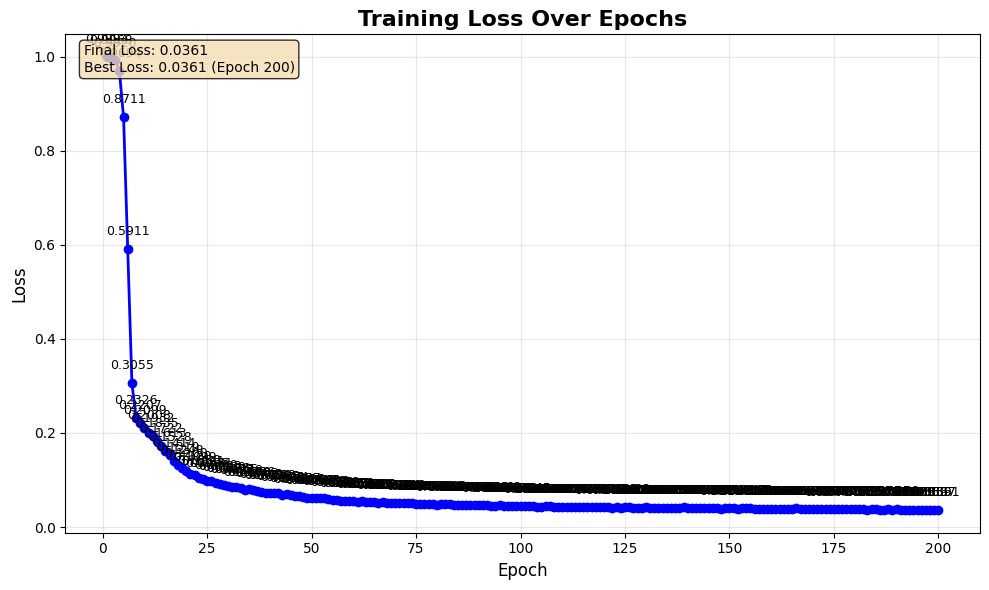

Training Summary:
Total epochs: 200
Final loss: 0.0361
Best loss: 0.0361 (Epoch 200)
Loss improvement: 96.4%


In [30]:
plot_training_loss(loss_history)

In [ ]:
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    model_components = checkpoint['model_components']
    noise_schedule = checkpoint['noise_schedule']
    training_info = checkpoint['training_info']
    
    for _, component in model_components.items():
        component.to(device)
        component.eval()

    print(f"Model loaded: {training_info['category']}, Loss: {training_info['final_loss']:.4f}")

    # Return in format expected by generate_simple_sketch
    loaded_model = {
        'model_components': model_components,
        'noise_schedule': noise_schedule,
        'training_info': training_info
    }

    return loaded_model

In [ ]:
def generate_simple_sketch(trained_model, category_id, seq_len, num_steps=500):
    device = setup_device()

    model_components = trained_model['model_components']
    noise_schedule = trained_model['noise_schedule']

    for component in model_components.values():
        component.eval()

    with torch.no_grad():
        # Start with random noise
        sketch = torch.randn(1, seq_len, 3, device=device)
        # Let the model generate pen states through diffusion!

        category = torch.tensor([category_id], device=device)

        # Denoising loop
        for step in range(num_steps):
            t = torch.tensor([num_steps - step - 1], device=device)

            if t >= len(noise_schedule['alphas']):
                t = torch.tensor([len(noise_schedule['alphas']) - 1], device=device)

            predicted_noise = model_forward_training(sketch, model_components, category, t)

            if step < num_steps - 1:
                alpha_t = noise_schedule['alphas'][t]
                beta_t = noise_schedule['betas'][t]
                alpha_cumprod_t = noise_schedule['alphas_cumprod'][t]
                noise = torch.randn_like(sketch)

                coeff1 = 1 / torch.sqrt(alpha_t)
                coeff2 = beta_t / torch.sqrt(1 - alpha_cumprod_t)

                # Denoise coordinates
                sketch[:, :, :2] = coeff1 * (sketch[:, :, :2] - coeff2 * predicted_noise[:, :, :2]) + torch.sqrt(beta_t) * noise[:, :, :2]
                pen_noise_scale = torch.sqrt(beta_t) * 0.1
                sketch[:, :, 2] = coeff1 * (sketch[:, :, 2] - coeff2 * predicted_noise[:, :, 2]) + pen_noise_scale * noise[:, :, 2]

            # Round and clamp pen states
            pen_states_raw = sketch[:, :, 2]
            pen_states_rounded = torch.round(pen_states_raw)
            pen_states_clamped = torch.clamp(pen_states_rounded, -1, 3)
            sketch[:, :, 2] = pen_states_clamped

        final_sketch = sketch[0].cpu().numpy()
        final_sketch[:, :2] = np.clip(final_sketch[:, :2], -1.0, 1.0)
        final_sketch[:, 2] = np.clip(np.round(final_sketch[:, 2]), -1, 3)

    return final_sketch

In [33]:
# Helper function to sketch the output
def plot_sketch(sketch, title):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # IMPROVED: Handle all pen states properly
    current_stroke = []
    strokes = []
    
    for i, (x, y, pen_state) in enumerate(sketch):
        if pen_state == -1:  # Padding - skip
            continue
        elif pen_state == 1:  # Start stroke
            if current_stroke:  # Finish previous stroke
                strokes.append(np.array(current_stroke))
            current_stroke = [(x, y)]
        elif pen_state == 2:  # Continue stroke
            current_stroke.append((x, y))
        elif pen_state == 0:  # End stroke
            current_stroke.append((x, y))
            strokes.append(np.array(current_stroke))
            current_stroke = []
        elif pen_state == 3:  # End of drawing
            if current_stroke:
                strokes.append(np.array(current_stroke))
            break
    
    # Add any remaining stroke
    if current_stroke:
        strokes.append(np.array(current_stroke))
    
    # Plot all strokes
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    for i, stroke in enumerate(strokes):
        if len(stroke) > 1:
            color = colors[i % len(colors)]
            ax.plot(stroke[:, 0], stroke[:, 1], color=color, linewidth=2.5, alpha=0.8)
            
            # Mark stroke start
            ax.scatter(stroke[0, 0], stroke[0, 1], c=color, s=50, marker='o', 
                      edgecolor='black', linewidth=1, zorder=5)
            
            # Mark stroke end  
            ax.scatter(stroke[-1, 0], stroke[-1, 1], c=color, s=50, marker='s', 
                      edgecolor='black', linewidth=1, zorder=5)
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Stroke Start'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=8, label='Stroke End'),
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [34]:
device = setup_device()

In [35]:
def quick_generate_bus(trained_model, seq_len=571):
    sketch = generate_simple_sketch(trained_model, 0, seq_len)
    plot_sketch(sketch, "Generated Bus")